# AttentionTrader Data Analysis

Basic analysis of the financial time series dataset collected from Yahoo Finance.

In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime

# Set up visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Data directory
data_dir = Path('data/yfinance')

## 1. Dataset Overview

In [115]:
# Get all CSV files
csv_files = list(data_dir.glob('*.csv'))
print(f"Total number of files: {len(csv_files)}")
print(f"\nFiles in dataset:")
for i, file in enumerate(sorted(csv_files), 1):
    print(f"{i:2d}. {file.stem}")

Total number of files: 91

Files in dataset:
 1. abbvie
 2. adobe
 3. alibaba
 4. alphabet
 5. amazon
 6. amd
 7. american_tower
 8. amgen
 9. apple
10. applied_materials
11. arm_holdings
12. asml
13. bank_of_america
14. berkshire_hathaway
15. binance_coin
16. bitcoin
17. boeing
18. booking_holdings
19. broadcom
20. caterpillar
21. chevron
22. coca_cola
23. coinbase
24. costco
25. crispr_therapeutics
26. crowdstrike
27. crude_oil
28. disney
29. dow_jones
30. duke_energy
31. eli_lilly
32. eth_usd
33. ethereum
34. exxonmobil
35. fortinet
36. freeport_mcmoran
37. general_electric
38. gold_futures
39. goldman_sachs
40. hdfc_bank
41. home_depot
42. illumina
43. intel
44. johnson_and_johnson
45. jpmorgan
46. linde
47. mastercard
48. mcdonalds
49. mercadolibre
50. meta
51. micron
52. microsoft
53. morgan_stanley
54. nasdaq100
55. netflix
56. nextera_energy
57. nike
58. novo_nordisk
59. nvidia
60. oklo_inc
61. okta
62. oracle
63. palantir
64. palo_alto_networks
65. paypal
66. pepsico
67. pfize

## 2. Load All Data and Analyze Coverage

In [116]:
# Load all datasets and collect metadata
datasets = {}
metadata = []

for file in csv_files:
    try:
        # Read CSV with header rows (yfinance creates multi-level headers)
        df = pd.read_csv(file, header=[0, 1, 2])
        
        # Flatten the multi-level columns and use Date as index
        df.columns = df.columns.get_level_values(0)
        df = df.set_index('Price')
        df.index.name = 'Date'
        
        # Convert index to datetime
        df.index = pd.to_datetime(df.index)
        
        # Remove any rows with invalid dates
        df = df[df.index.notna()]
        
        ticker_name = file.stem
        datasets[ticker_name] = df
        
        if len(df) > 0:
            metadata.append({
                'Ticker': ticker_name,
                'Rows': len(df),
                'Start Date': df.index.min(),
                'End Date': df.index.max(),
                'Days': (df.index.max() - df.index.min()).days,
                'Columns': ', '.join(df.columns)
            })
    except Exception as e:
        print(f"Error loading {file.stem}: {e}")

# Create metadata DataFrame
metadata_df = pd.DataFrame(metadata)
metadata_df = metadata_df.sort_values('Days', ascending=False)

print(f"Successfully loaded {len(datasets)} datasets")
print(f"\nDataset Statistics:")
print(f"Total rows across all files: {metadata_df['Rows'].sum():,}")
print(f"Average rows per file: {metadata_df['Rows'].mean():.0f}")
print(f"Median rows per file: {metadata_df['Rows'].median():.0f}")

Successfully loaded 91 datasets

Dataset Statistics:
Total rows across all files: 757,021
Average rows per file: 8319
Median rows per file: 7751


In [117]:
# Display detailed metadata table
print("\nDetailed Dataset Information:")
print("=" * 100)
metadata_df.style.format({
    'Rows': '{:,}',
    'Days': '{:,}'
})


Detailed Dataset Information:


## 3. Temporal Coverage Analysis

In [118]:
# Temporal statistics
print("Temporal Coverage Statistics:")
print(f"\nEarliest data point: {metadata_df['Start Date'].min()}")
print(f"Latest data point: {metadata_df['End Date'].max()}")
print(f"\nLongest history: {metadata_df.iloc[0]['Ticker']} ({metadata_df.iloc[0]['Days']:,} days)")
print(f"Shortest history: {metadata_df.iloc[-1]['Ticker']} ({metadata_df.iloc[-1]['Days']:,} days)")
print(f"\nAverage coverage: {metadata_df['Days'].mean():.0f} days ({metadata_df['Days'].mean()/365:.1f} years)")
print(f"Median coverage: {metadata_df['Days'].median():.0f} days ({metadata_df['Days'].median()/365:.1f} years)")

Temporal Coverage Statistics:

Earliest data point: 1927-12-30 00:00:00
Latest data point: 2025-12-30 00:00:00

Longest history: sp500 (35,795 days)
Shortest history: arm_holdings (838 days)

Average coverage: 11990 days (32.9 years)
Median coverage: 11248 days (30.8 years)


## 4. Visualize Data Coverage

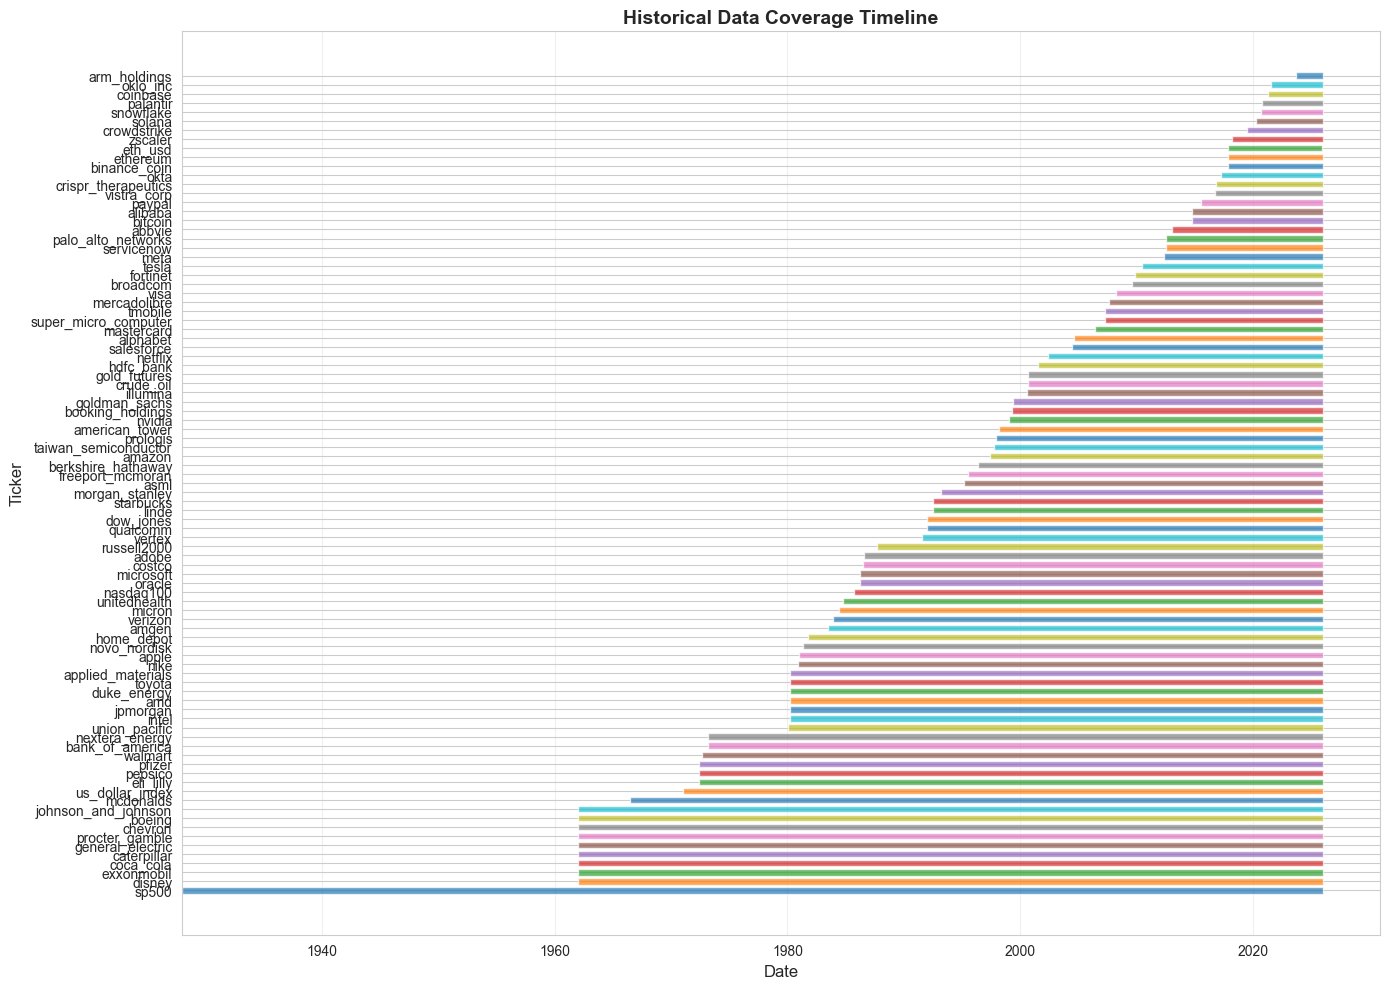

In [119]:
# Plot timeline of data coverage
fig, ax = plt.subplots(figsize=(14, 10))

# Sort by start date for better visualization
plot_df = metadata_df.sort_values('Start Date')

for idx, row in plot_df.iterrows():
    ax.barh(row['Ticker'], 
            width=(row['End Date'] - row['Start Date']).days,
            left=row['Start Date'],
            height=0.7,
            alpha=0.7)

ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Ticker', fontsize=12)
ax.set_title('Historical Data Coverage Timeline', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

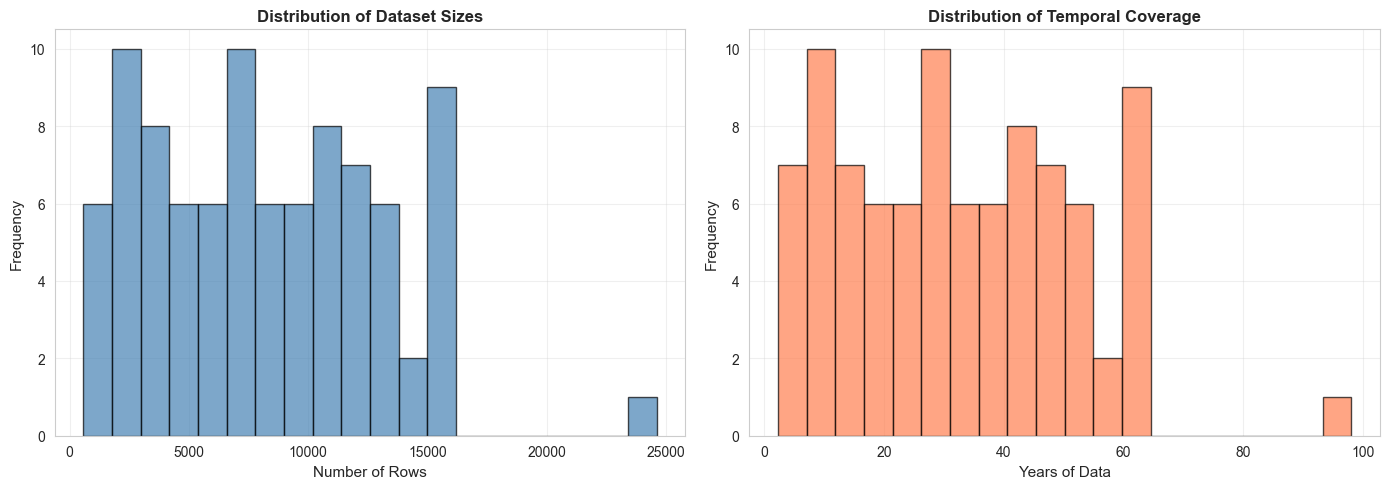

In [120]:
# Distribution of data points
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of number of rows
axes[0].hist(metadata_df['Rows'], bins=20, alpha=0.7, color='steelblue', edgecolor='black')
axes[0].set_xlabel('Number of Rows', fontsize=11)
axes[0].set_ylabel('Frequency', fontsize=11)
axes[0].set_title('Distribution of Dataset Sizes', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Histogram of time coverage in years
axes[1].hist(metadata_df['Days']/365, bins=20, alpha=0.7, color='coral', edgecolor='black')
axes[1].set_xlabel('Years of Data', fontsize=11)
axes[1].set_ylabel('Frequency', fontsize=11)
axes[1].set_title('Distribution of Temporal Coverage', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Top 10 Datasets by Coverage

In [121]:
# Top 10 by number of days
top_10_days = metadata_df.nlargest(10, 'Days')[['Ticker', 'Days', 'Rows', 'Start Date', 'End Date']].copy()
top_10_days['Years'] = (top_10_days['Days'] / 365).round(1)

print("Top 10 Datasets by Historical Coverage:")
print(top_10_days.to_string(index=False))

Top 10 Datasets by Historical Coverage:
             Ticker  Days  Rows Start Date   End Date  Years
              sp500 35795 24616 1927-12-30 2025-12-30   98.1
             disney 23373 16107 1962-01-02 2025-12-30   64.0
         exxonmobil 23373 16107 1962-01-02 2025-12-30   64.0
          coca_cola 23373 16107 1962-01-02 2025-12-30   64.0
        caterpillar 23373 16107 1962-01-02 2025-12-30   64.0
   general_electric 23373 16107 1962-01-02 2025-12-30   64.0
     procter_gamble 23373 16107 1962-01-02 2025-12-30   64.0
            chevron 23373 16107 1962-01-02 2025-12-30   64.0
             boeing 23373 16107 1962-01-02 2025-12-30   64.0
johnson_and_johnson 23373 16107 1962-01-02 2025-12-30   64.0


In [122]:
# Top 10 by number of rows
top_10_rows = metadata_df.nlargest(10, 'Rows')[['Ticker', 'Rows', 'Days', 'Start Date', 'End Date']].copy()
top_10_rows['Years'] = (top_10_rows['Days'] / 365).round(1)

print("Top 10 Datasets by Number of Data Points:")
print(top_10_rows.to_string(index=False))

Top 10 Datasets by Number of Data Points:
             Ticker  Rows  Days Start Date   End Date  Years
              sp500 24616 35795 1927-12-30 2025-12-30   98.1
             disney 16107 23373 1962-01-02 2025-12-30   64.0
         exxonmobil 16107 23373 1962-01-02 2025-12-30   64.0
          coca_cola 16107 23373 1962-01-02 2025-12-30   64.0
        caterpillar 16107 23373 1962-01-02 2025-12-30   64.0
   general_electric 16107 23373 1962-01-02 2025-12-30   64.0
     procter_gamble 16107 23373 1962-01-02 2025-12-30   64.0
            chevron 16107 23373 1962-01-02 2025-12-30   64.0
             boeing 16107 23373 1962-01-02 2025-12-30   64.0
johnson_and_johnson 16107 23373 1962-01-02 2025-12-30   64.0


## 6. Sample Data Examination

In [123]:
# Examine a sample dataset (Apple)
if 'apple' in datasets:
    apple_df = datasets['apple']
    
    print("Apple (AAPL) Dataset Sample:")
    print(f"\nShape: {apple_df.shape}")
    print(f"\nColumns: {list(apple_df.columns)}")
    print(f"\nFirst 5 rows:")
    display(apple_df.head())
    print(f"\nLast 5 rows:")
    display(apple_df.tail())
    print(f"\nBasic Statistics:")
    display(apple_df.describe())

Apple (AAPL) Dataset Sample:

Shape: (11353, 5)

Columns: ['Close', 'High', 'Low', 'Open', 'Volume']

First 5 rows:


Close      High       Low      Open     Volume
Date                                                         
1980-12-12  0.098390  0.098817  0.098390  0.098390  469033600
1980-12-15  0.093256  0.093684  0.093256  0.093684  175884800
1980-12-16  0.086412  0.086839  0.086412  0.086839  105728000
1980-12-17  0.088550  0.088978  0.088550  0.088550   86441600
1980-12-18  0.091118  0.091545  0.091118  0.091118   73449600


Last 5 rows:


Close        High         Low        Open    Volume
Date                                                                
2025-12-22  270.970001  273.880005  270.510010  272.859985  36571800
2025-12-23  272.359985  272.500000  269.559998  270.839996  29642000
2025-12-24  273.809998  275.429993  272.200012  272.339996  17910600
2025-12-26  273.399994  275.369995  272.859985  274.160004  21521800
2025-12-29  273.760010  274.359985  272.350006  272.690002  23700400


Basic Statistics:


Close          High           Low          Open        Volume
count  11353.000000  11353.000000  11353.000000  11353.000000  1.135300e+04
mean      27.922097     28.201901     27.616034     27.899366  3.097813e+08
std       57.735201     58.297926     57.112904     57.677995  3.334136e+08
min        0.037645      0.038072      0.037645      0.038072  0.000000e+00
25%        0.245552      0.252168      0.240371      0.245770  1.063148e+08
50%        0.481518      0.491103      0.469960      0.480006  1.989008e+08
75%       21.497242     21.703527     21.226205     21.442098  3.902556e+08
max      286.190002    288.619995    283.299988    286.200012  7.421641e+09

## 7. Data Quality Check

In [124]:
# Check for missing values across all datasets
missing_data = []

for name, df in datasets.items():
    missing_count = df.isnull().sum().sum()
    total_cells = df.shape[0] * df.shape[1]
    missing_pct = (missing_count / total_cells) * 100 if total_cells > 0 else 0
    
    missing_data.append({
        'Ticker': name,
        'Missing Values': missing_count,
        'Total Cells': total_cells,
        'Missing %': round(missing_pct, 2)
    })

missing_df = pd.DataFrame(missing_data)
missing_df = missing_df.sort_values('Missing %', ascending=False)

print("Data Quality Summary:")
print(f"\nDatasets with missing values: {(missing_df['Missing Values'] > 0).sum()}")
print(f"Total missing values across all datasets: {missing_df['Missing Values'].sum():,}")

if (missing_df['Missing Values'] > 0).any():
    print("\nDatasets with missing values:")
    print(missing_df[missing_df['Missing Values'] > 0].to_string(index=False))
else:
    print("\n✓ No missing values found in any dataset!")

Data Quality Summary:

Datasets with missing values: 0
Total missing values across all datasets: 0

✓ No missing values found in any dataset!


## 8. Category Breakdown

In [125]:
# Categorize tickers by type (matching load_data.py structure)
categories = {
    # Technology & AI
    'Big Tech': ['apple', 'microsoft', 'alphabet', 'nvidia', 'meta', 'amazon', 'tesla'],
    'Semiconductors & Hardware': ['amd', 'broadcom', 'arm_holdings', 'micron', 'super_micro_computer', 'intel', 'qualcomm', 'applied_materials'],
    'Cloud, Software & SaaS': ['salesforce', 'oracle', 'servicenow', 'palantir', 'snowflake', 'adobe'],
    'Cybersecurity': ['palo_alto_networks', 'crowdstrike', 'fortinet', 'zscaler', 'okta'],
    
    # Finance & Fintech
    'Banking & Conglomerates': ['jpmorgan', 'bank_of_america', 'goldman_sachs', 'morgan_stanley', 'berkshire_hathaway'],
    'Payments & Fintech': ['visa', 'mastercard', 'paypal', 'block', 'coinbase'],
    
    # Healthcare & Biotech
    'Weight Loss & Longevity': ['eli_lilly', 'novo_nordisk'],
    'Pharmaceuticals & Insurance': ['unitedhealth', 'johnson_and_johnson', 'pfizer', 'abbvie', 'amgen'],
    'Genomics & Innovation': ['illumina', 'crispr_therapeutics', 'vertex'],
    
    # Consumer Sectors
    'Consumer Discretionary': ['mcdonalds', 'starbucks', 'nike', 'booking_holdings', 'home_depot', 'costco'],
    'Consumer Staples': ['walmart', 'coca_cola', 'pepsico', 'procter_gamble'],
    
    # Energy, Materials & Industrials
    'Energy': ['exxonmobil', 'chevron', 'nextera_energy', 'vistra_corp', 'oklo_inc'],
    'Industrials & Materials': ['caterpillar', 'union_pacific', 'boeing', 'general_electric', 'linde', 'freeport_mcmoran'],
    
    # Real Estate & Utilities
    'Real Estate & Utilities': ['prologis', 'american_tower', 'duke_energy'],
    
    # Telecom & Media
    'Telecom & Media': ['verizon', 'tmobile', 'netflix', 'disney'],
    
    # International & Crypto
    'International': ['taiwan_semiconductor', 'asml', 'toyota', 'alibaba', 'hdfc_bank', 'mercadolibre'],
    'Crypto': ['bitcoin', 'ethereum', 'solana', 'binance_coin'],
    
    # Indices & Macro
    'Indices & Macro': ['sp500', 'nasdaq100', 'dow_jones', 'russell2000', 'us_dollar_index', 'gold_futures', 'crude_oil']
}

category_stats = []
for category, tickers in categories.items():
    ticker_data = metadata_df[metadata_df['Ticker'].isin(tickers)]
    category_stats.append({
        'Category': category,
        'Count': len(ticker_data),
        'Avg Days': ticker_data['Days'].mean(),
        'Avg Rows': ticker_data['Rows'].mean(),
        'Total Rows': ticker_data['Rows'].sum()
    })

category_df = pd.DataFrame(category_stats)
category_df = category_df.sort_values('Total Rows', ascending=False)

print("Dataset Breakdown by Category:")
print(category_df.to_string(index=False))

Dataset Breakdown by Category:
                   Category  Count     Avg Days     Avg Rows  Total Rows
            Indices & Macro      7 16499.714286 11379.285714       79655
    Industrials & Materials      6 18383.000000 12671.666667       76030
  Semiconductors & Hardware      8 11434.000000  7886.875000       63095
     Consumer Discretionary      6 15132.000000 10434.500000       62607
           Consumer Staples      4 21450.250000 14792.500000       59170
Pharmaceuticals & Insurance      5 15654.800000 10796.800000       53984
                     Energy      5 14212.000000  9798.000000       48990
                   Big Tech      7  9960.571429  6865.714286       48060
    Banking & Conglomerates      5 13718.200000  9461.400000       47307
              International      6  9674.500000  6667.500000       40005
            Telecom & Media      4 13551.000000  9340.500000       37362
     Cloud, Software & SaaS      6  7593.666667  5235.000000       31410
    Real Estate & Ut

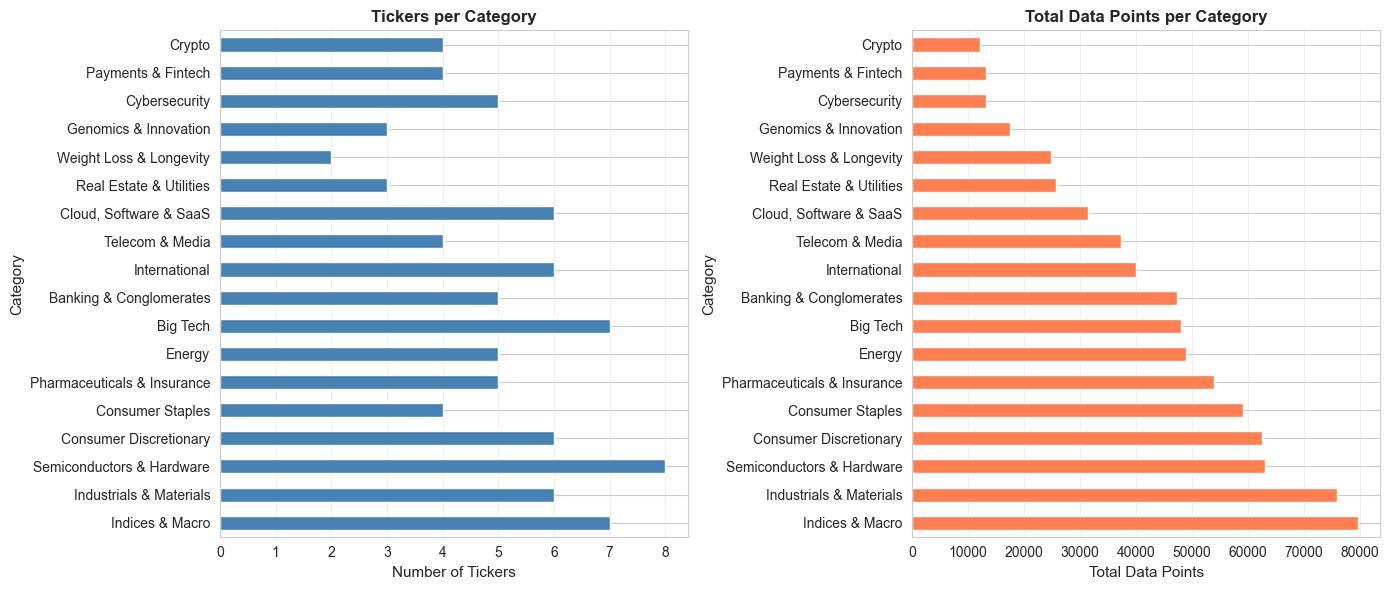

In [126]:
# Visualize category distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Number of tickers per category
category_df.plot(x='Category', y='Count', kind='barh', ax=axes[0], 
                  color='steelblue', legend=False)
axes[0].set_xlabel('Number of Tickers', fontsize=11)
axes[0].set_ylabel('Category', fontsize=11)
axes[0].set_title('Tickers per Category', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='x')

# Total data points per category
category_df.plot(x='Category', y='Total Rows', kind='barh', ax=axes[1], 
                  color='coral', legend=False)
axes[1].set_xlabel('Total Data Points', fontsize=11)
axes[1].set_ylabel('Category', fontsize=11)
axes[1].set_title('Total Data Points per Category', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

## 9. Price and Volume Visualization by Category

Visualize close prices and trading volumes for all tickers within each category.

In [ ]:
def plot_category_chart(category_name, ticker_list, datasets, save_path='./images'):
    """
    Create a dual-axis chart for a category showing:
    - Close prices as line plots
    - Volume as histogram in background
    - Save chart as PNG file
    """
    # Filter available tickers and sort for consistent ordering
    available_tickers = sorted([t for t in ticker_list if t in datasets])
    
    if not available_tickers:
        print(f"No data available for {category_name}")
        return
    
    # Create figure with dual y-axes
    fig, ax1 = plt.subplots(figsize=(16, 8))
    ax2 = ax1.twinx()
    
    # Color palette for line plots
    colors = plt.cm.tab10(np.linspace(0, 1, len(available_tickers)))
    
    # Plot volume as histogram in background (on secondary axis)
    for idx, ticker in enumerate(available_tickers):
        df = datasets[ticker]
        if 'Volume' in df.columns:
            # Normalize volume for better visualization across different scales
            volume_normalized = df['Volume'] / df['Volume'].max() if df['Volume'].max() > 0 else df['Volume']
            ax2.fill_between(df.index, 0, volume_normalized, 
                            alpha=0.1, color=colors[idx])
    
    # Plot close prices on primary axis
    for idx, ticker in enumerate(available_tickers):
        df = datasets[ticker]
        if 'Close' in df.columns:
            ax1.plot(df.index, df['Close'], 
                    label=ticker.replace('_', ' ').title(),
                    linewidth=2, color=colors[idx], alpha=0.8)
    
    # Customize primary axis (prices)
    ax1.set_xlabel('Date', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Close Price (USD)', fontsize=12, fontweight='bold')
    ax1.set_title(f'{category_name} - Historical Close Prices with Volume',
                 fontsize=14, fontweight='bold', pad=20)
    ax1.grid(True, alpha=0.3, linestyle='--')
    ax1.legend(loc='upper left', fontsize=9, framealpha=0.9)
    
    # Customize secondary axis (volume)
    ax2.set_ylabel('Normalized Volume', fontsize=12, fontweight='bold', alpha=0.7)
    ax2.set_ylim(0, 1.2)  # Normalized volume range
    ax2.tick_params(axis='y', labelcolor='gray', labelsize=9)
    
    # Format x-axis
    fig.autofmt_xdate()
    
    plt.tight_layout()
    
    # Save the chart as PNG
    from pathlib import Path
    import os
    
    # Create images directory if it doesn't exist
    Path(save_path).mkdir(parents=True, exist_ok=True)
    
    # Sanitize filename: replace spaces and special characters with underscores
    filename = category_name.lower().replace(' ', '_').replace('&', 'and').replace(',', '')
    filepath = os.path.join(save_path, f'{filename}.png')
    
    # Save with high DPI for quality
    plt.savefig(filepath, dpi=150, bbox_inches='tight')
    print(f"Chart saved: {filepath}")
    
    plt.show()

print("Function defined: plot_category_chart()")

### 9.1 Big Tech

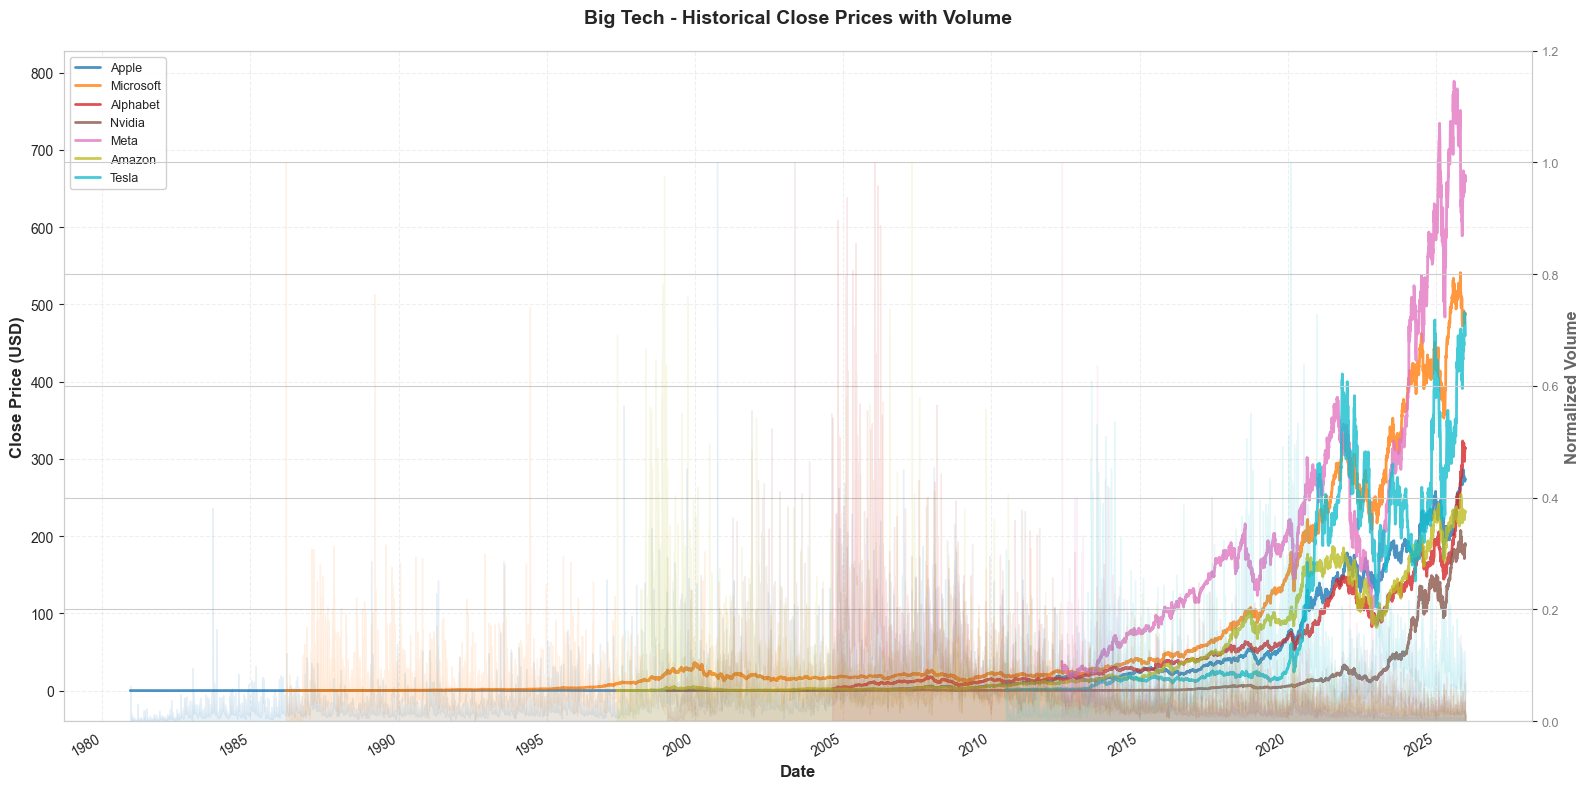

In [128]:
plot_category_chart('Big Tech', categories['Big Tech'], datasets)

### 9.2 Semiconductors & Hardware

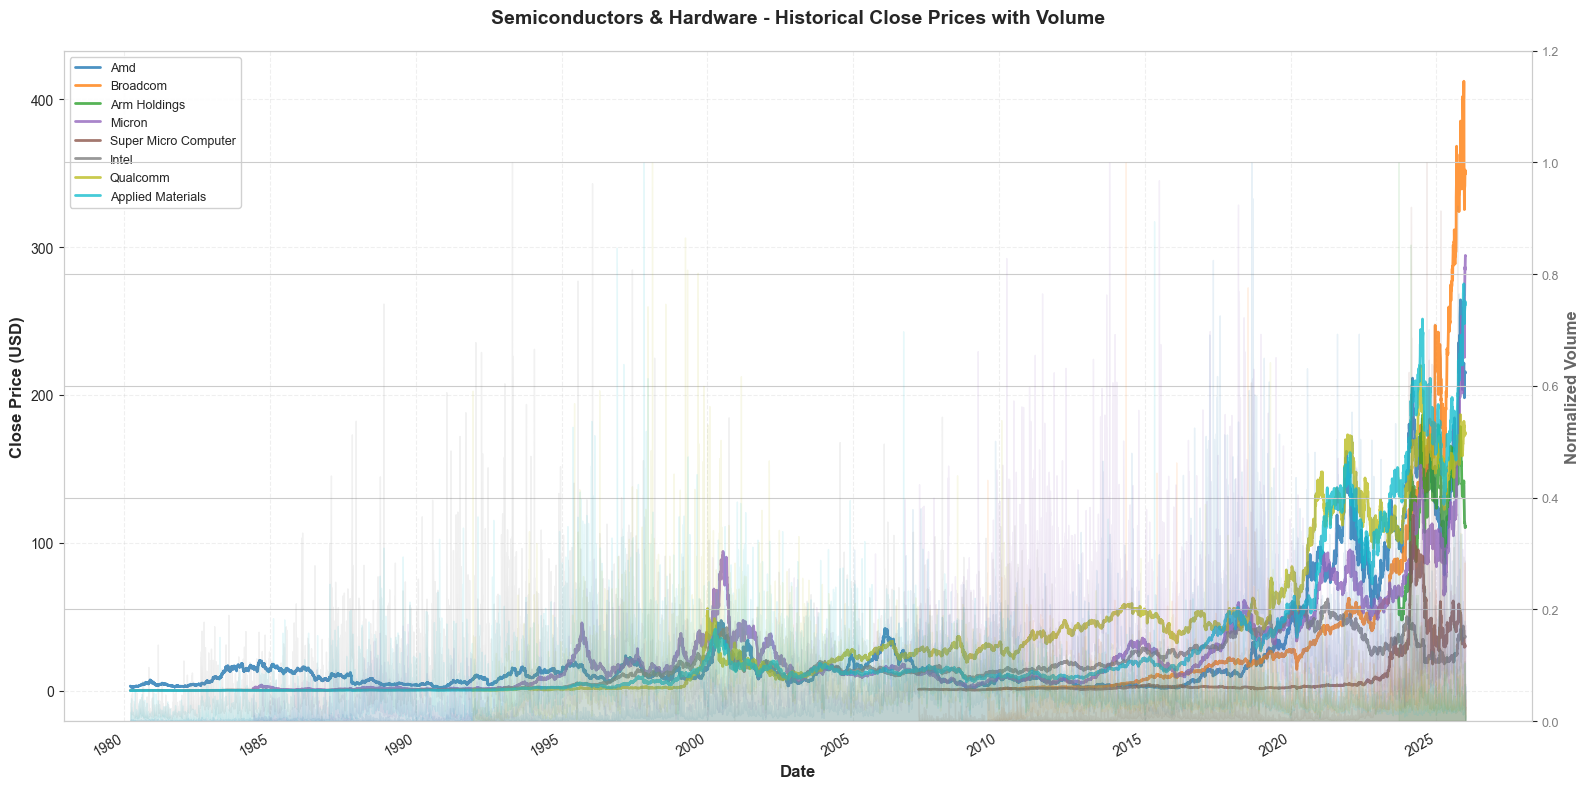

In [129]:
plot_category_chart('Semiconductors & Hardware', categories['Semiconductors & Hardware'], datasets)

### 9.3 Cloud, Software & SaaS

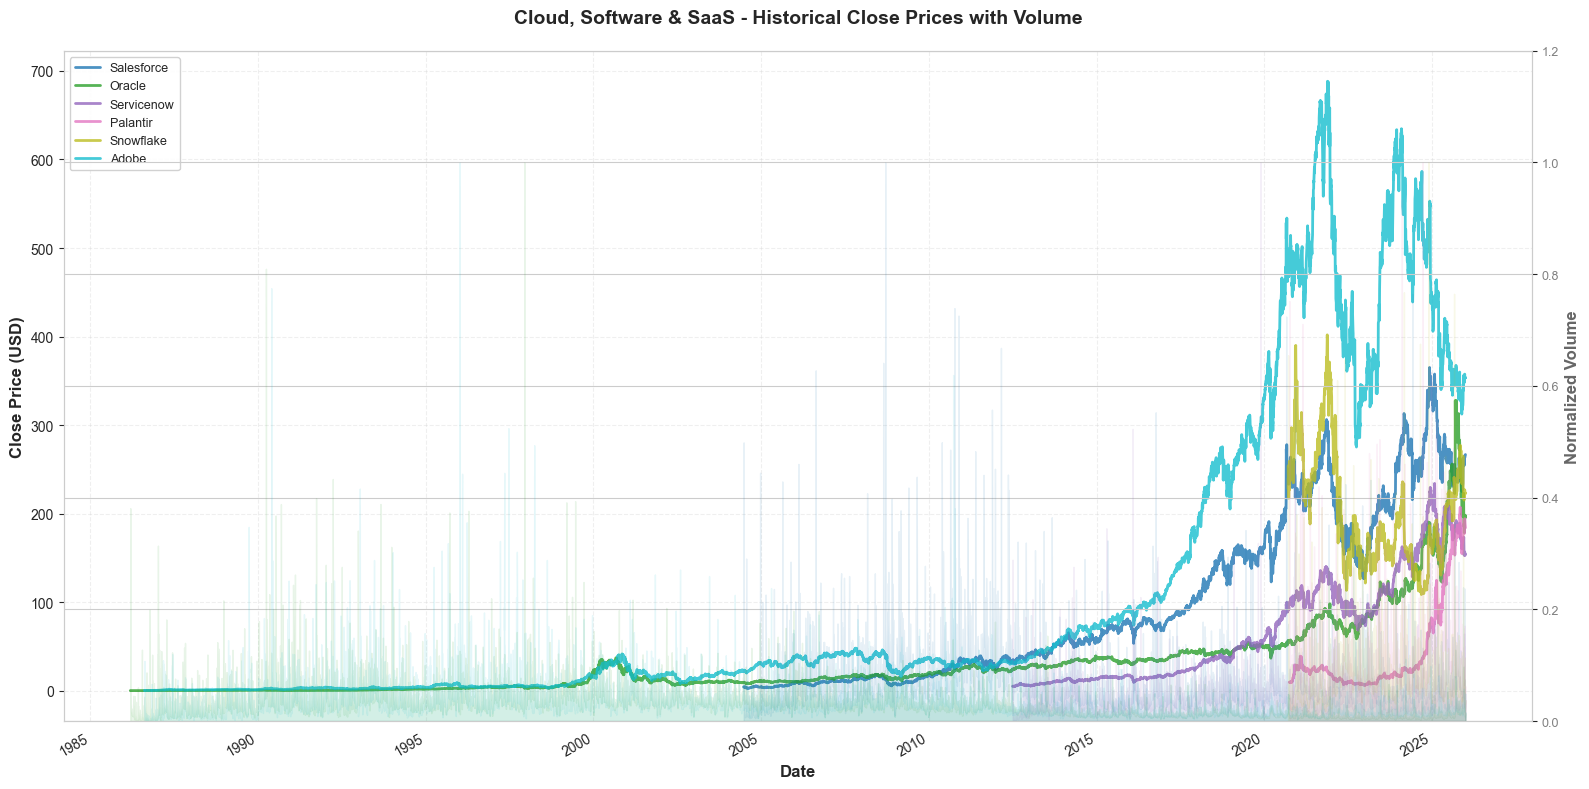

In [130]:
plot_category_chart('Cloud, Software & SaaS', categories['Cloud, Software & SaaS'], datasets)

### 9.4 Cybersecurity

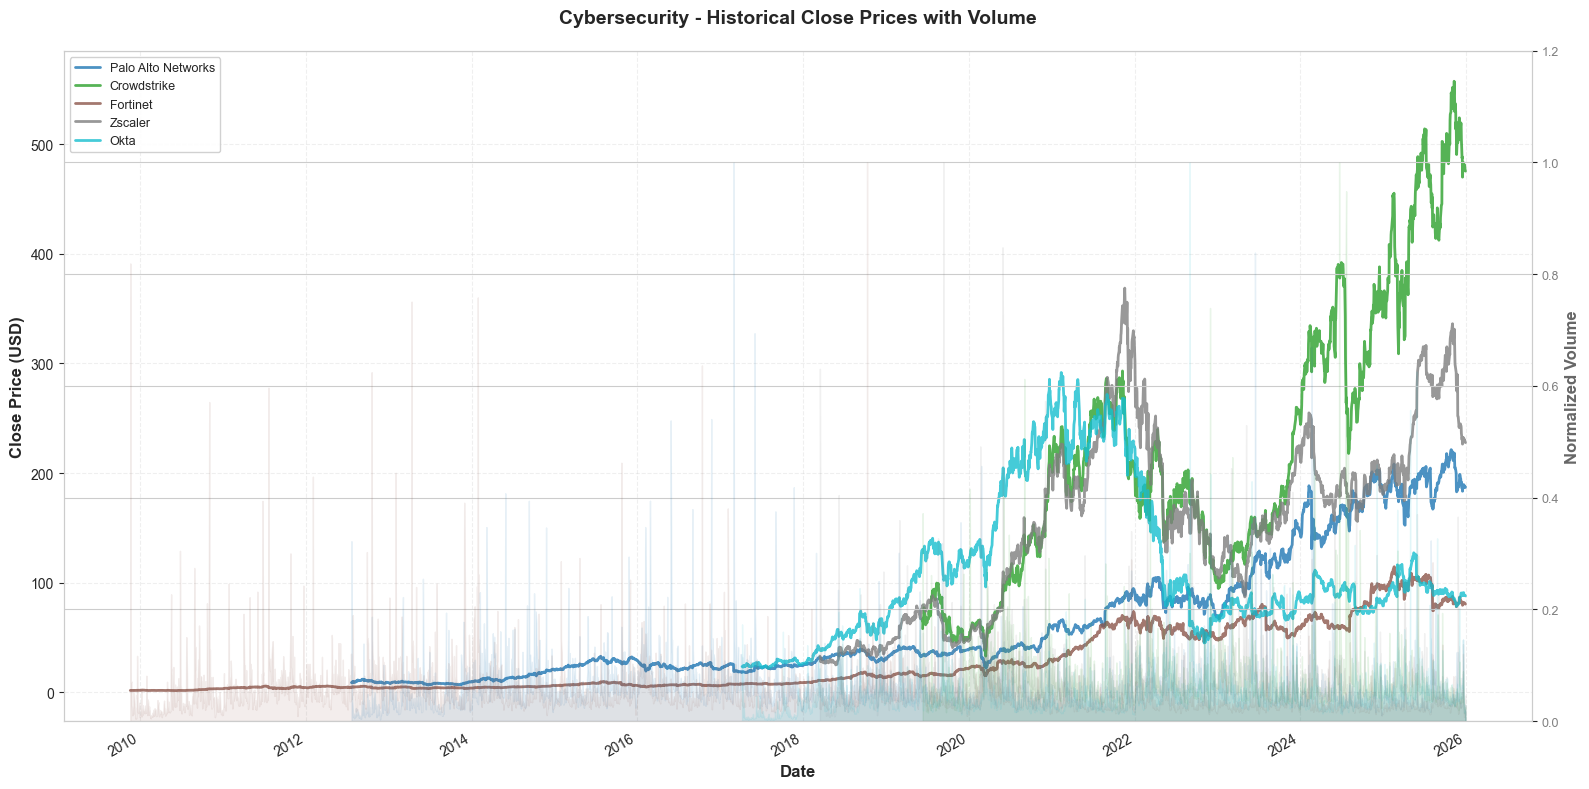

In [131]:
plot_category_chart('Cybersecurity', categories['Cybersecurity'], datasets)

### 9.5 Banking & Conglomerates

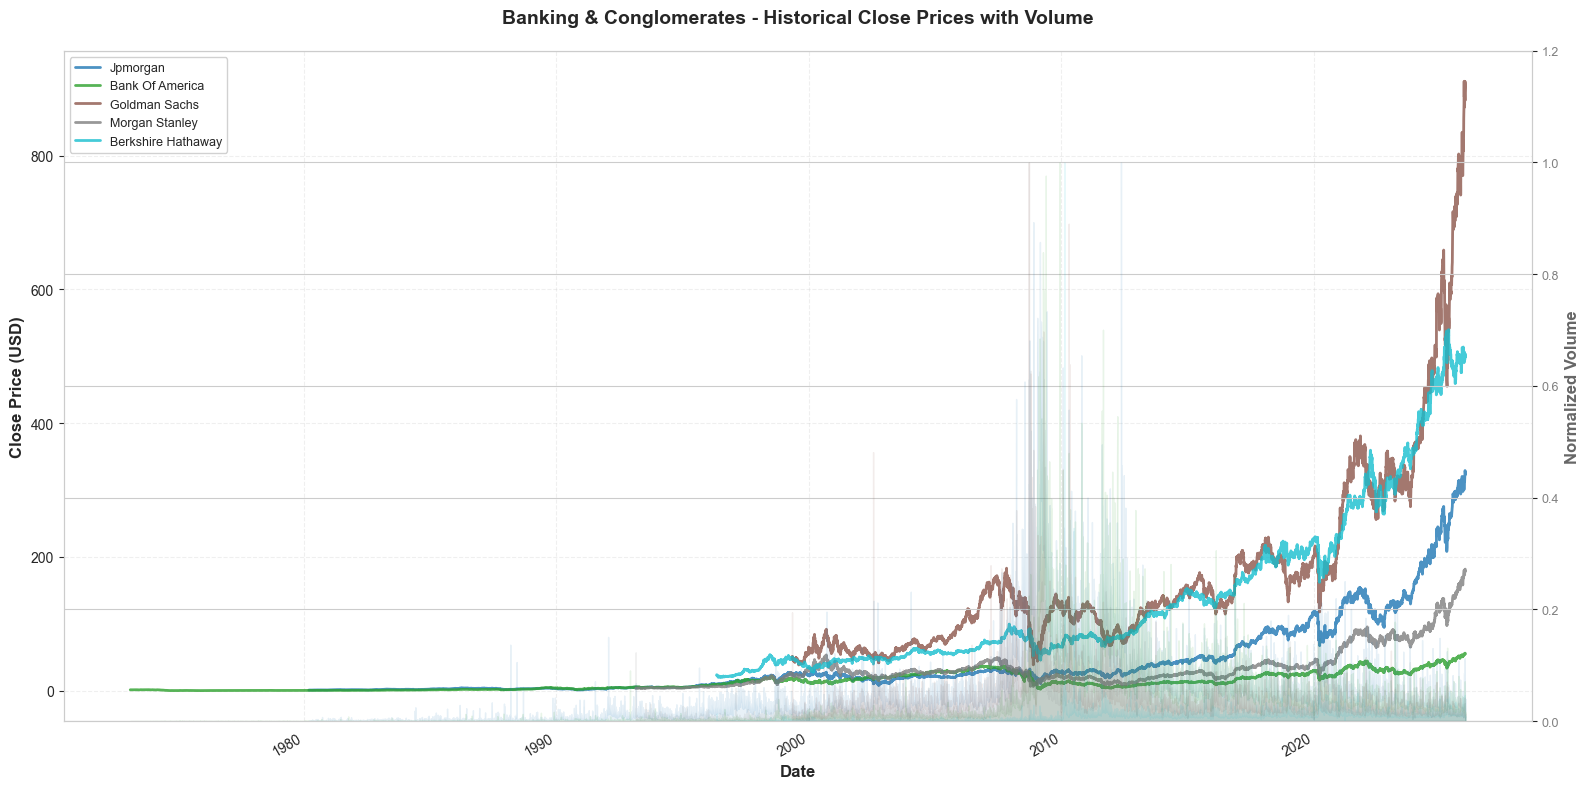

In [132]:
plot_category_chart('Banking & Conglomerates', categories['Banking & Conglomerates'], datasets)

### 9.6 Payments & Fintech

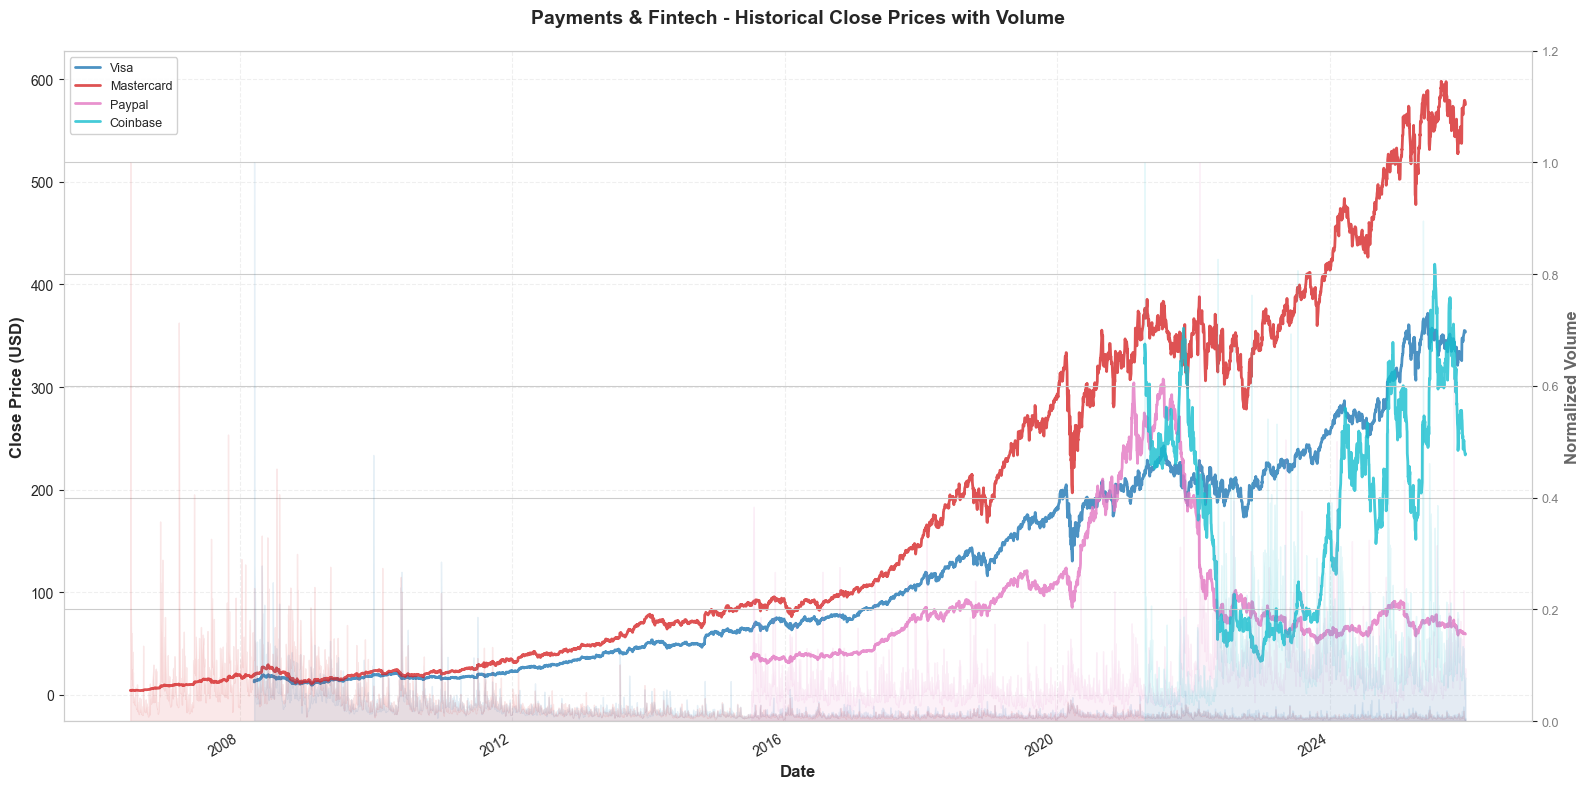

In [133]:
plot_category_chart('Payments & Fintech', categories['Payments & Fintech'], datasets)

### 9.7 Weight Loss & Longevity

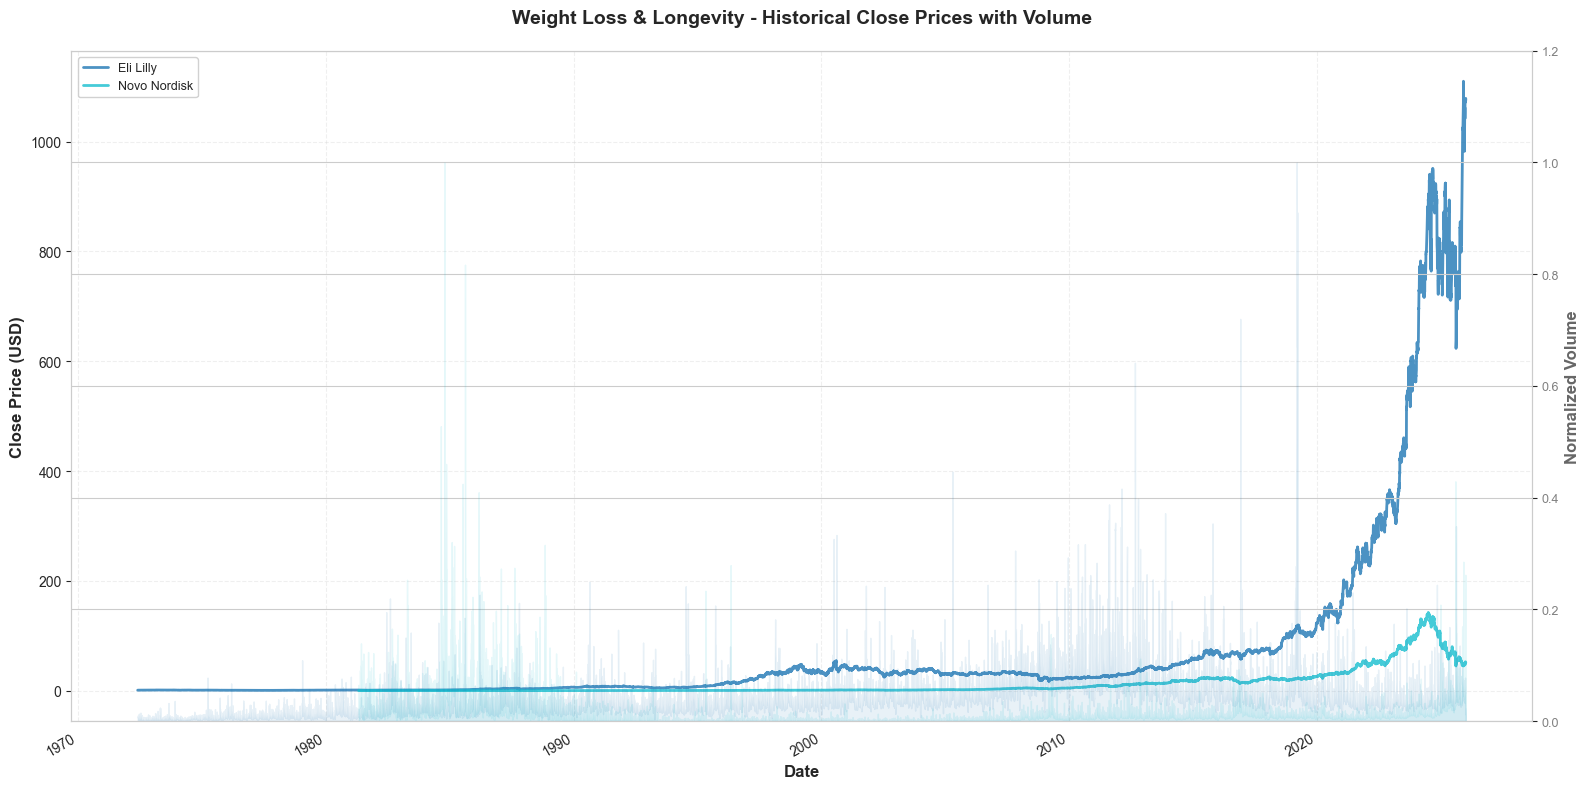

In [134]:
plot_category_chart('Weight Loss & Longevity', categories['Weight Loss & Longevity'], datasets)

### 9.8 Pharmaceuticals & Insurance

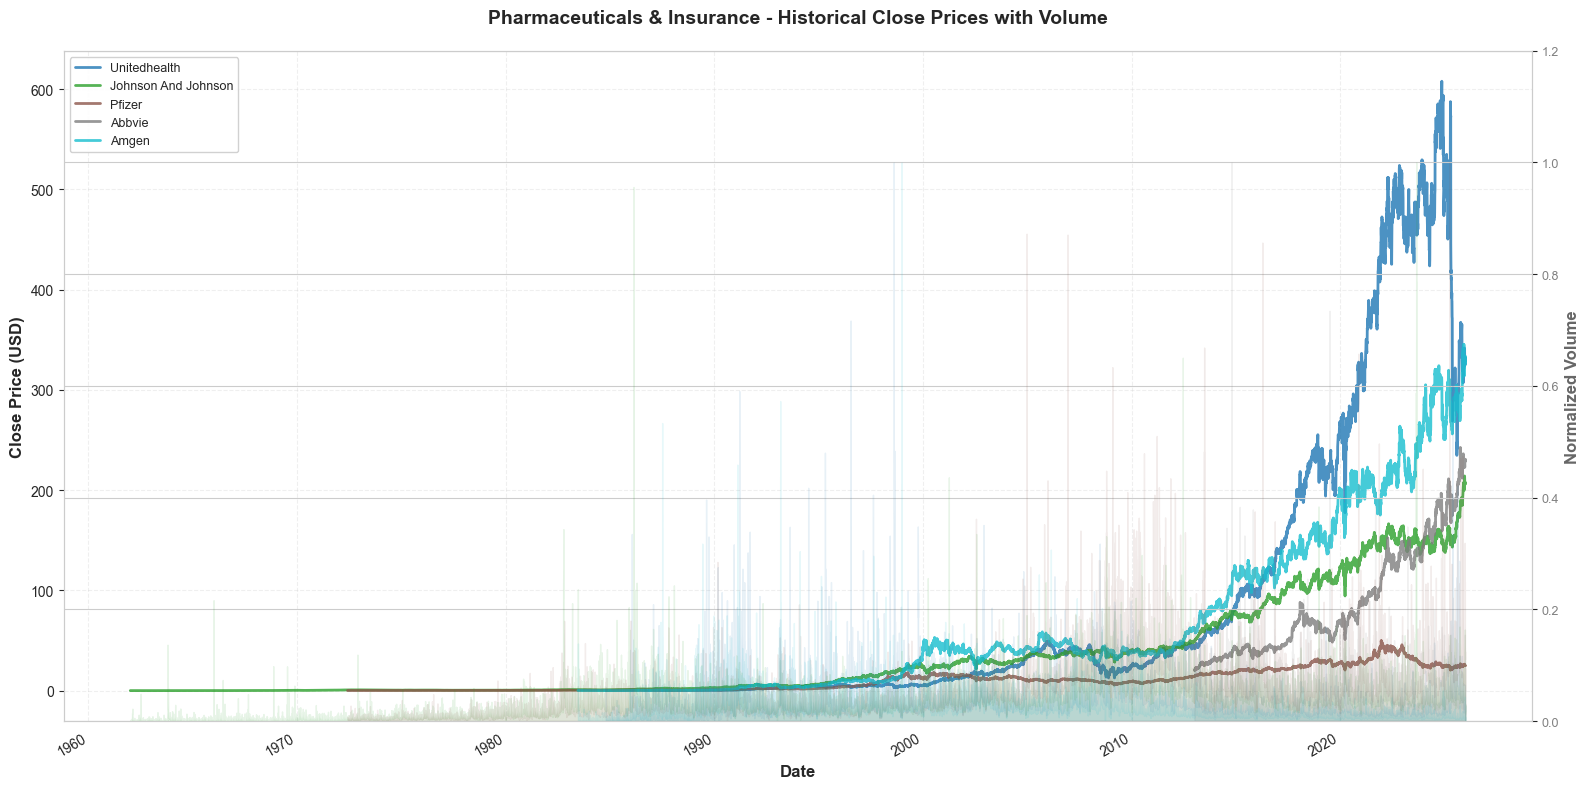

In [135]:
plot_category_chart('Pharmaceuticals & Insurance', categories['Pharmaceuticals & Insurance'], datasets)

### 9.9 Genomics & Innovation

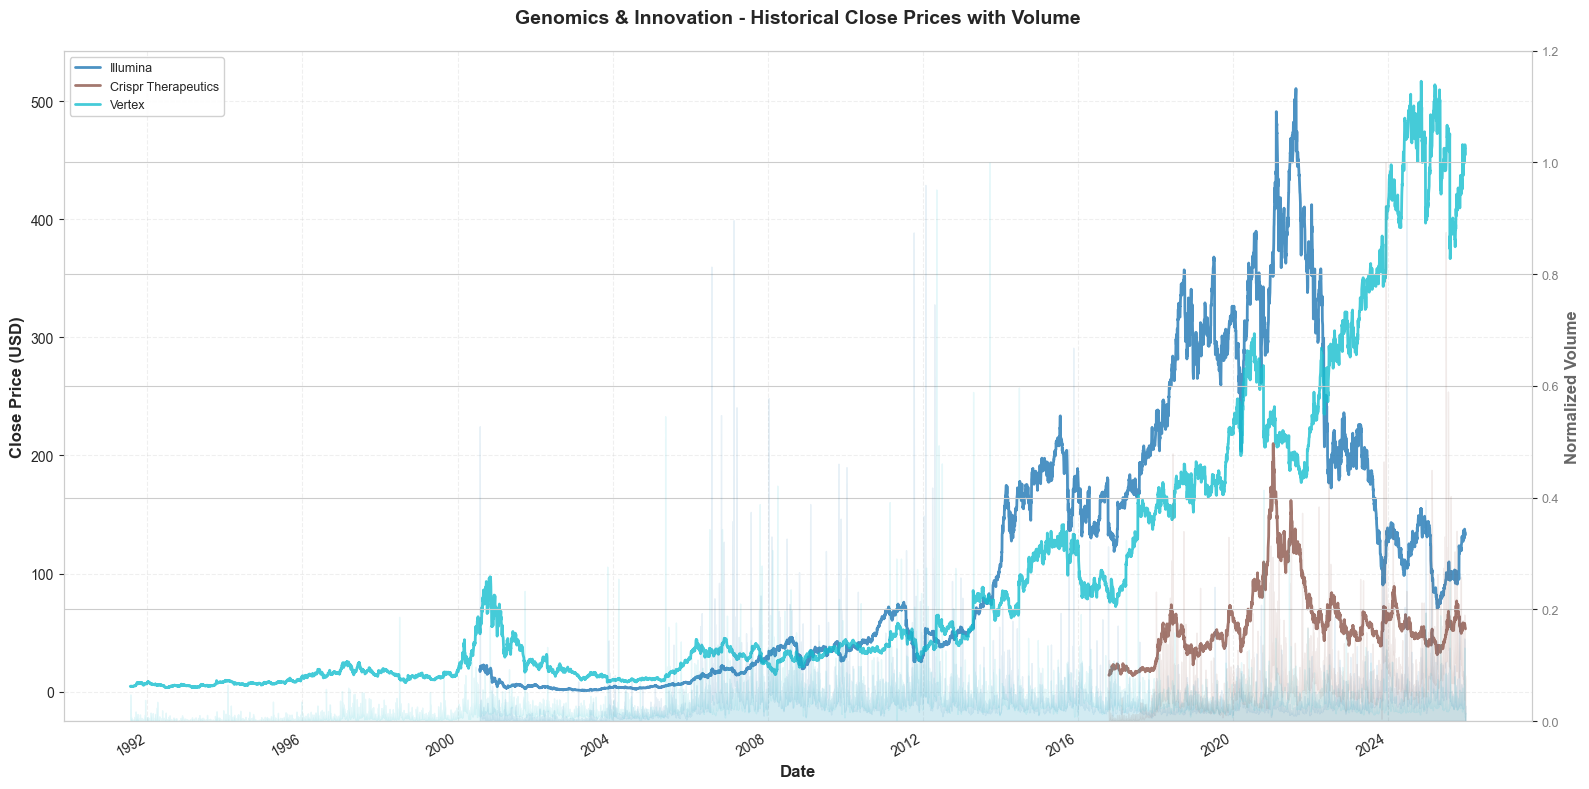

In [136]:
plot_category_chart('Genomics & Innovation', categories['Genomics & Innovation'], datasets)

### 9.10 Consumer Discretionary

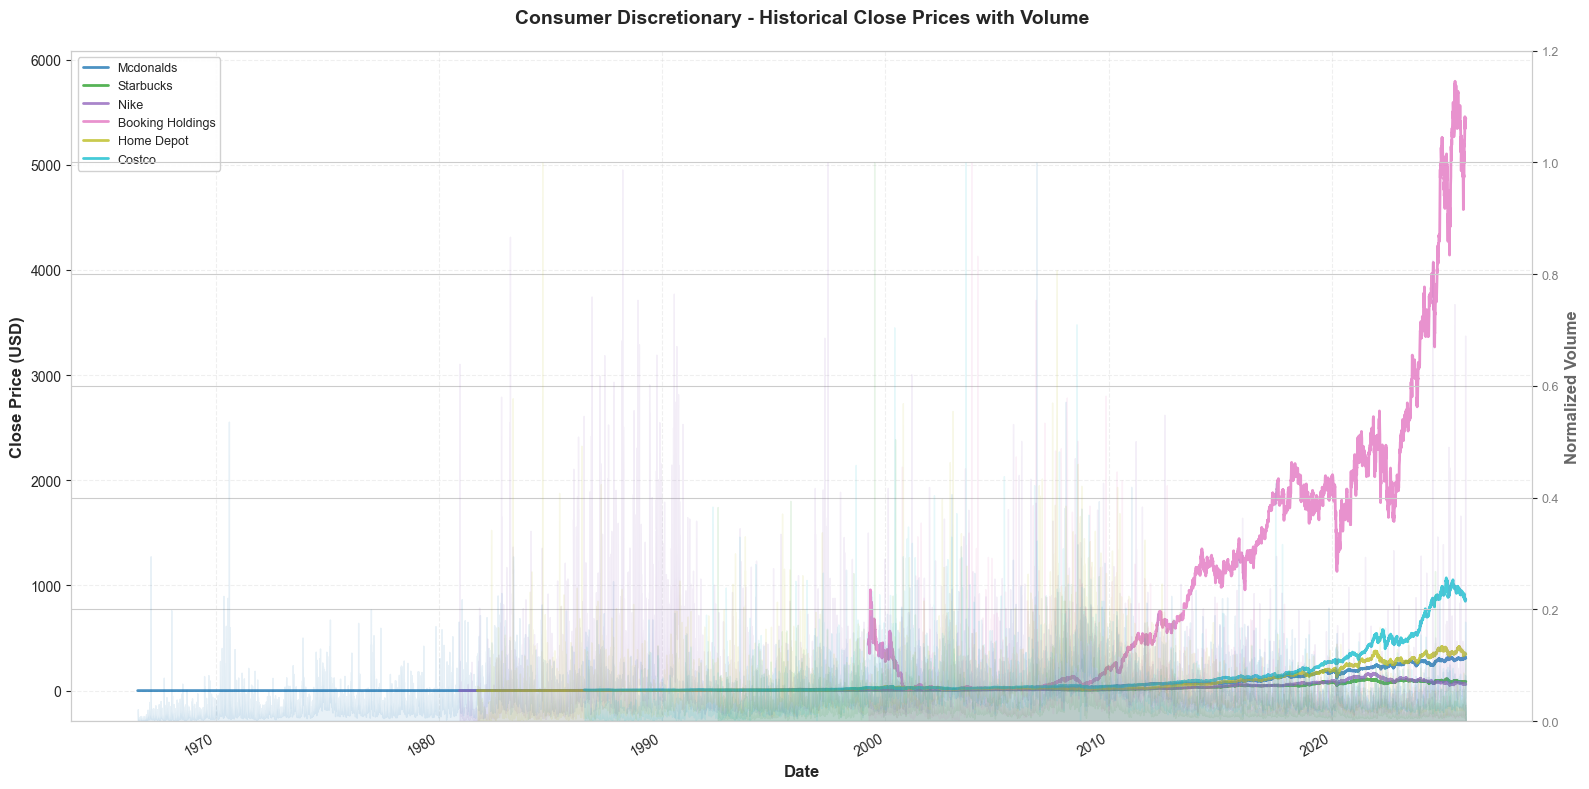

In [137]:
plot_category_chart('Consumer Discretionary', categories['Consumer Discretionary'], datasets)

### 9.11 Consumer Staples

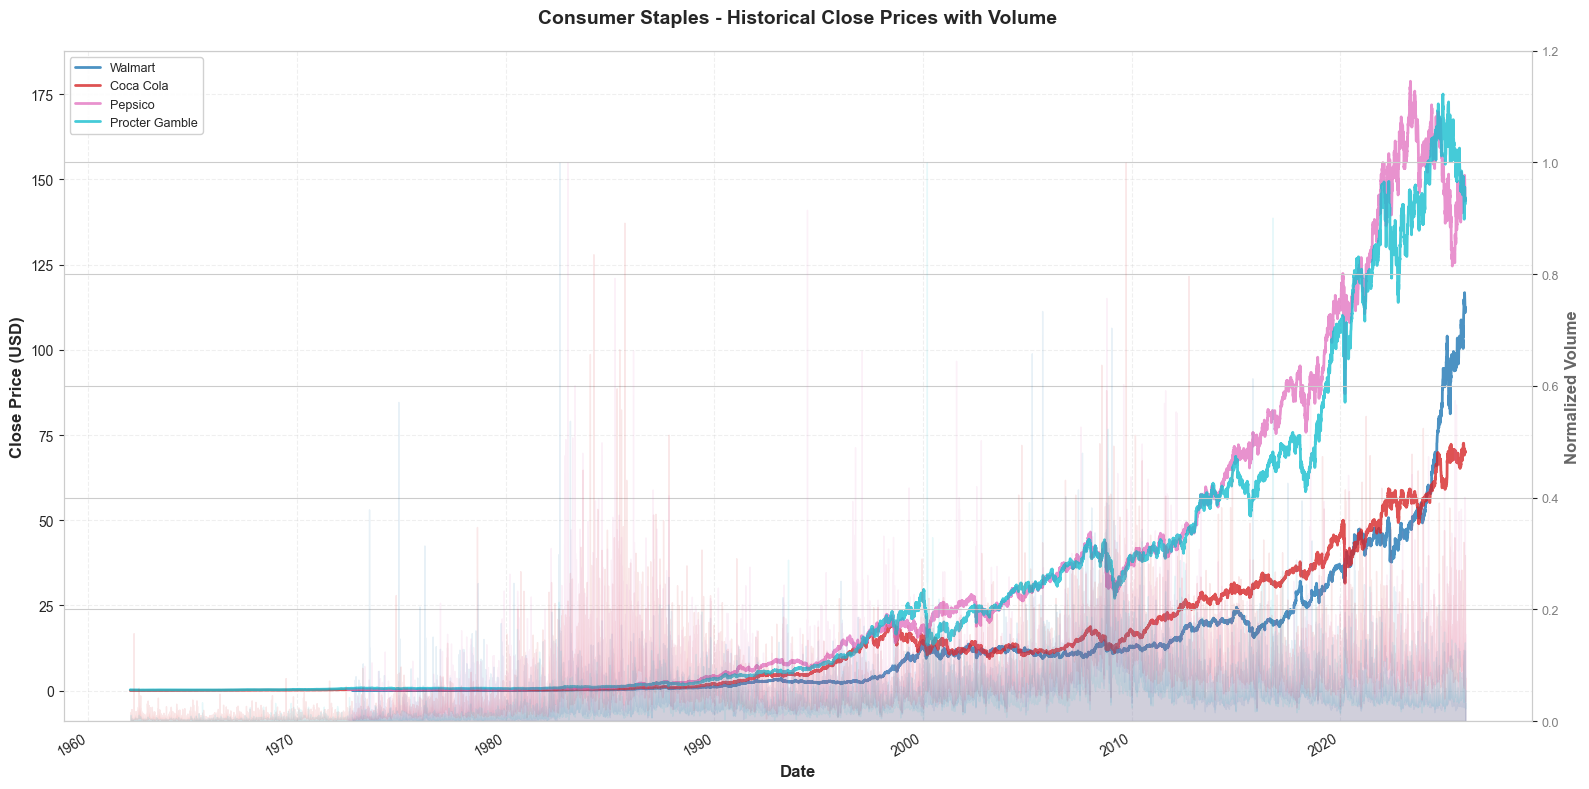

In [138]:
plot_category_chart('Consumer Staples', categories['Consumer Staples'], datasets)

### 9.12 Energy

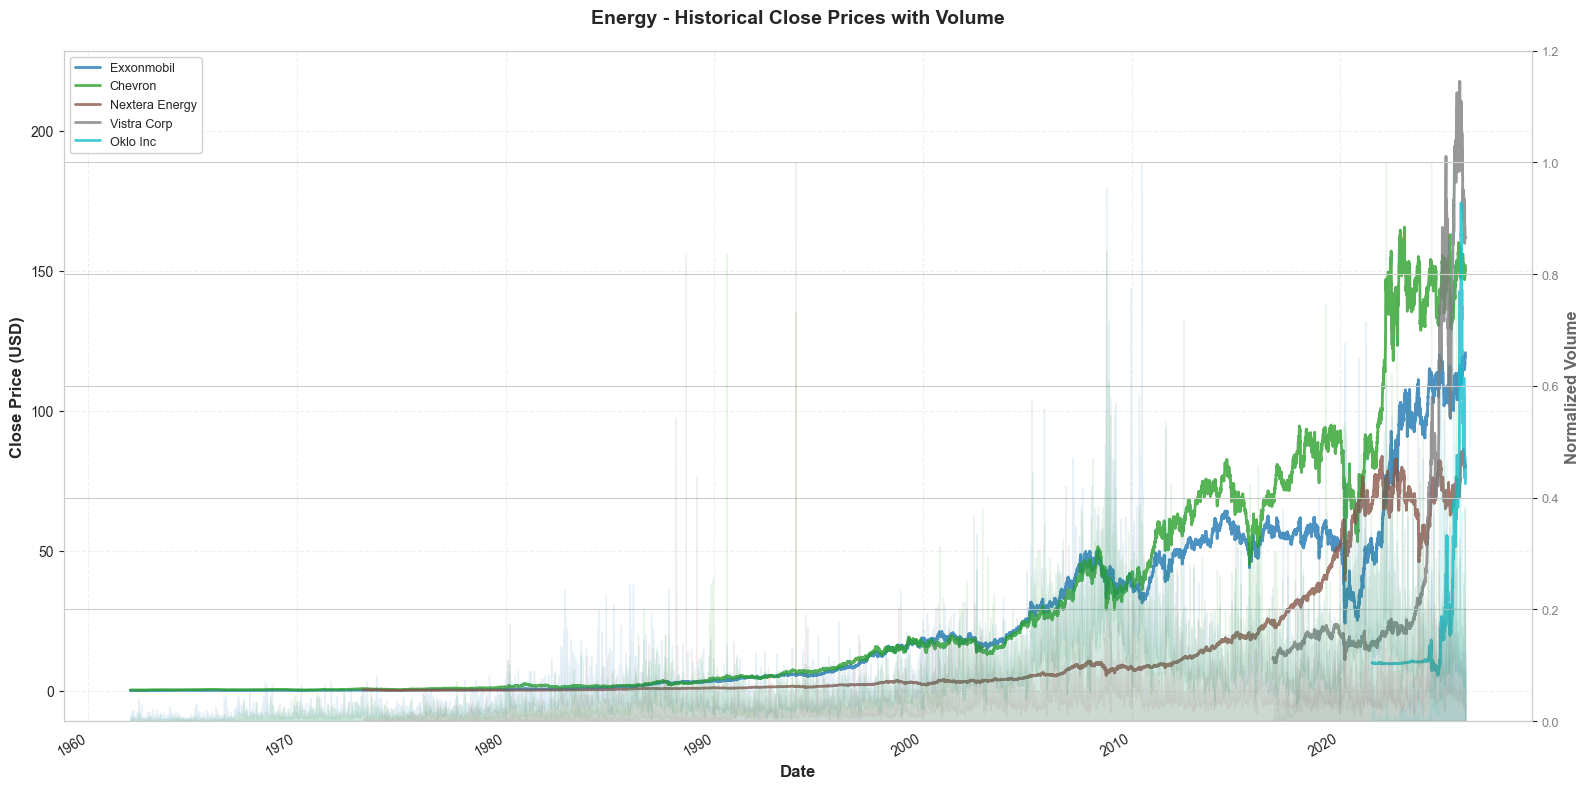

In [139]:
plot_category_chart('Energy', categories['Energy'], datasets)

### 9.13 Industrials & Materials

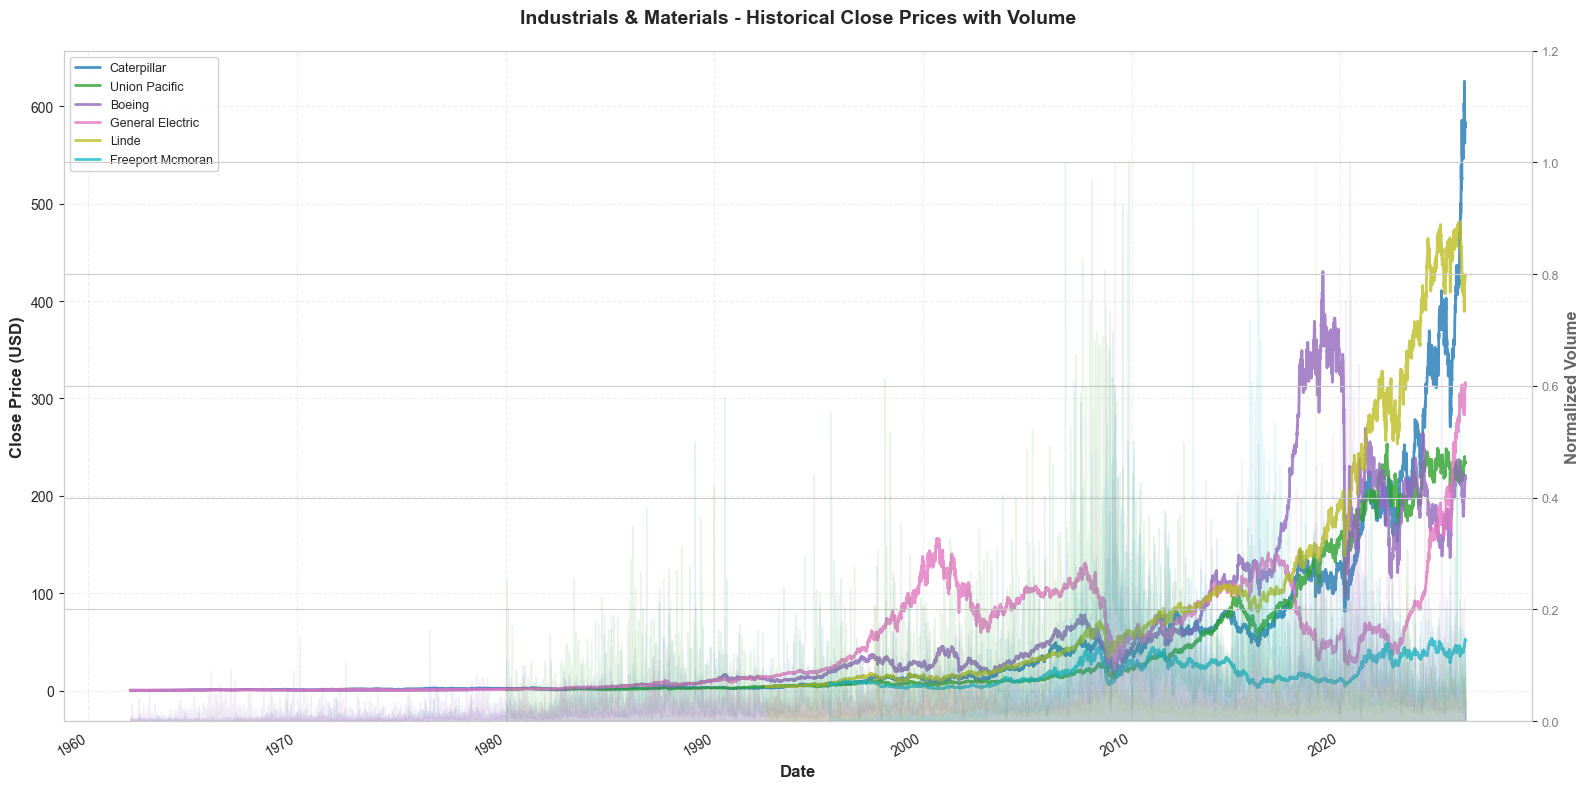

In [140]:
plot_category_chart('Industrials & Materials', categories['Industrials & Materials'], datasets)

### 9.14 Real Estate & Utilities

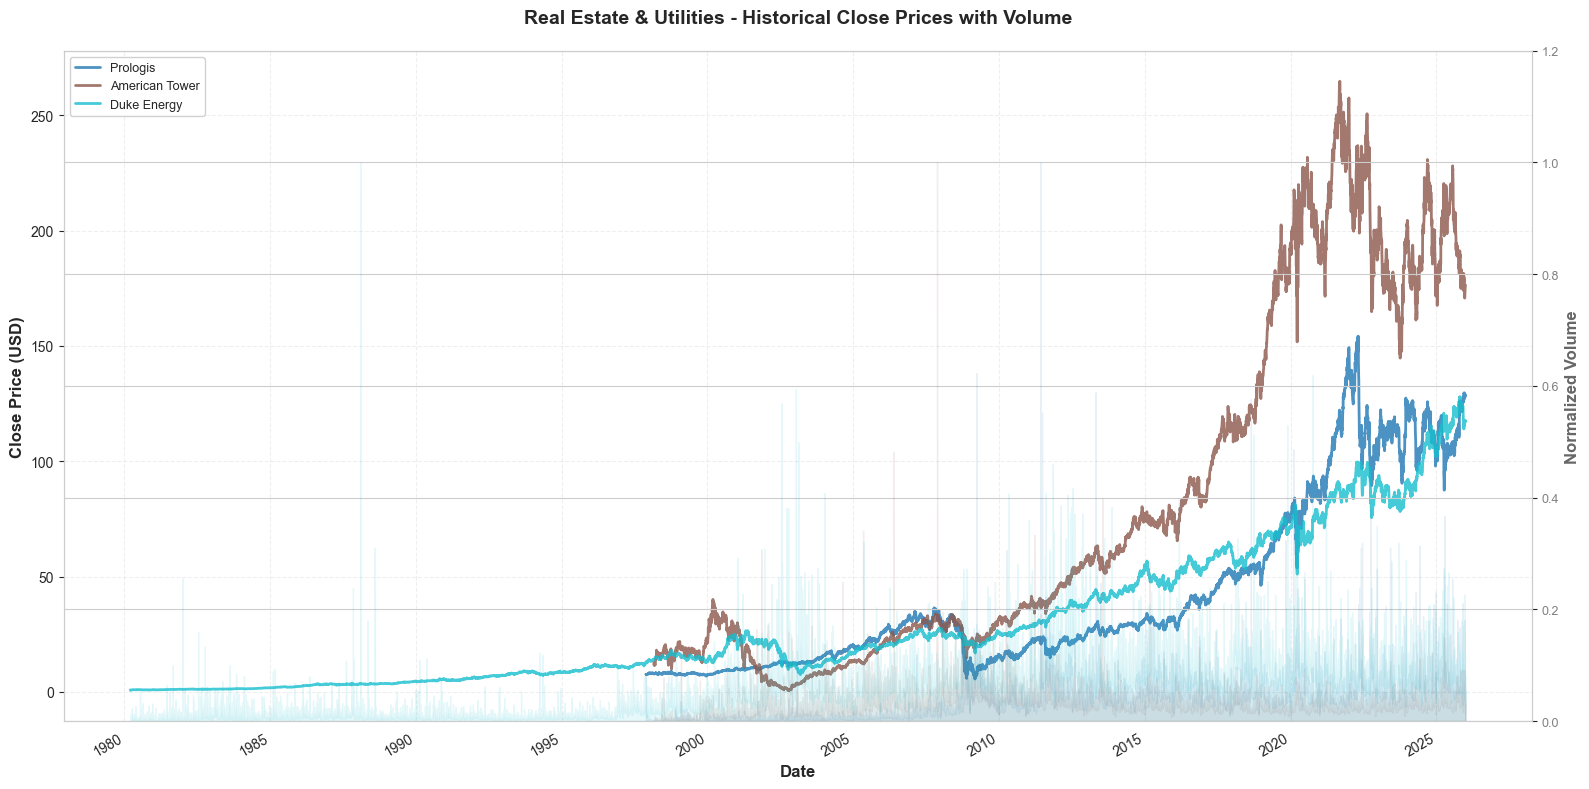

In [141]:
plot_category_chart('Real Estate & Utilities', categories['Real Estate & Utilities'], datasets)

### 9.15 Telecom & Media

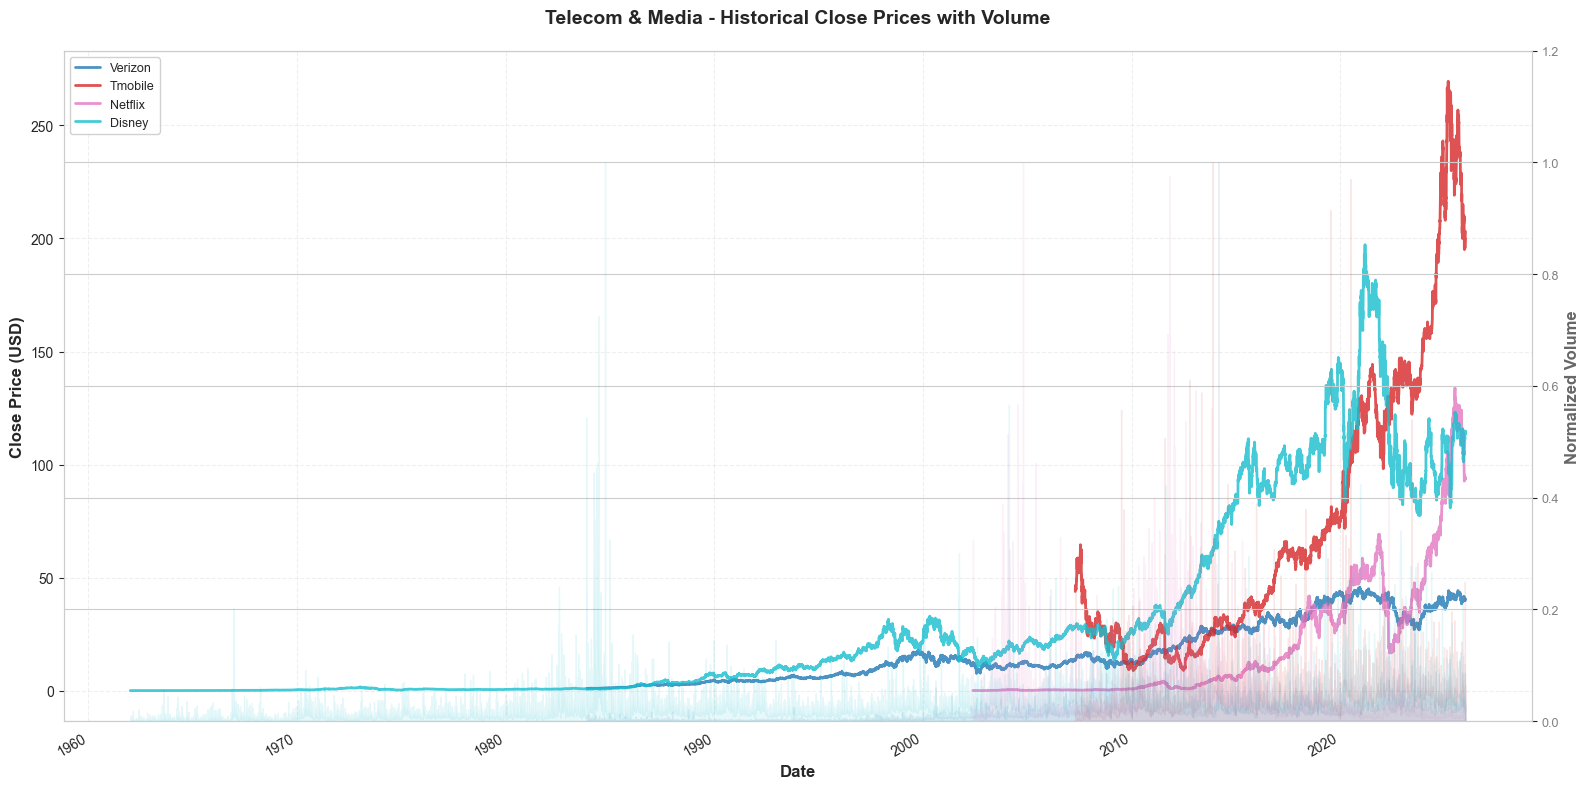

In [142]:
plot_category_chart('Telecom & Media', categories['Telecom & Media'], datasets)

### 9.16 International

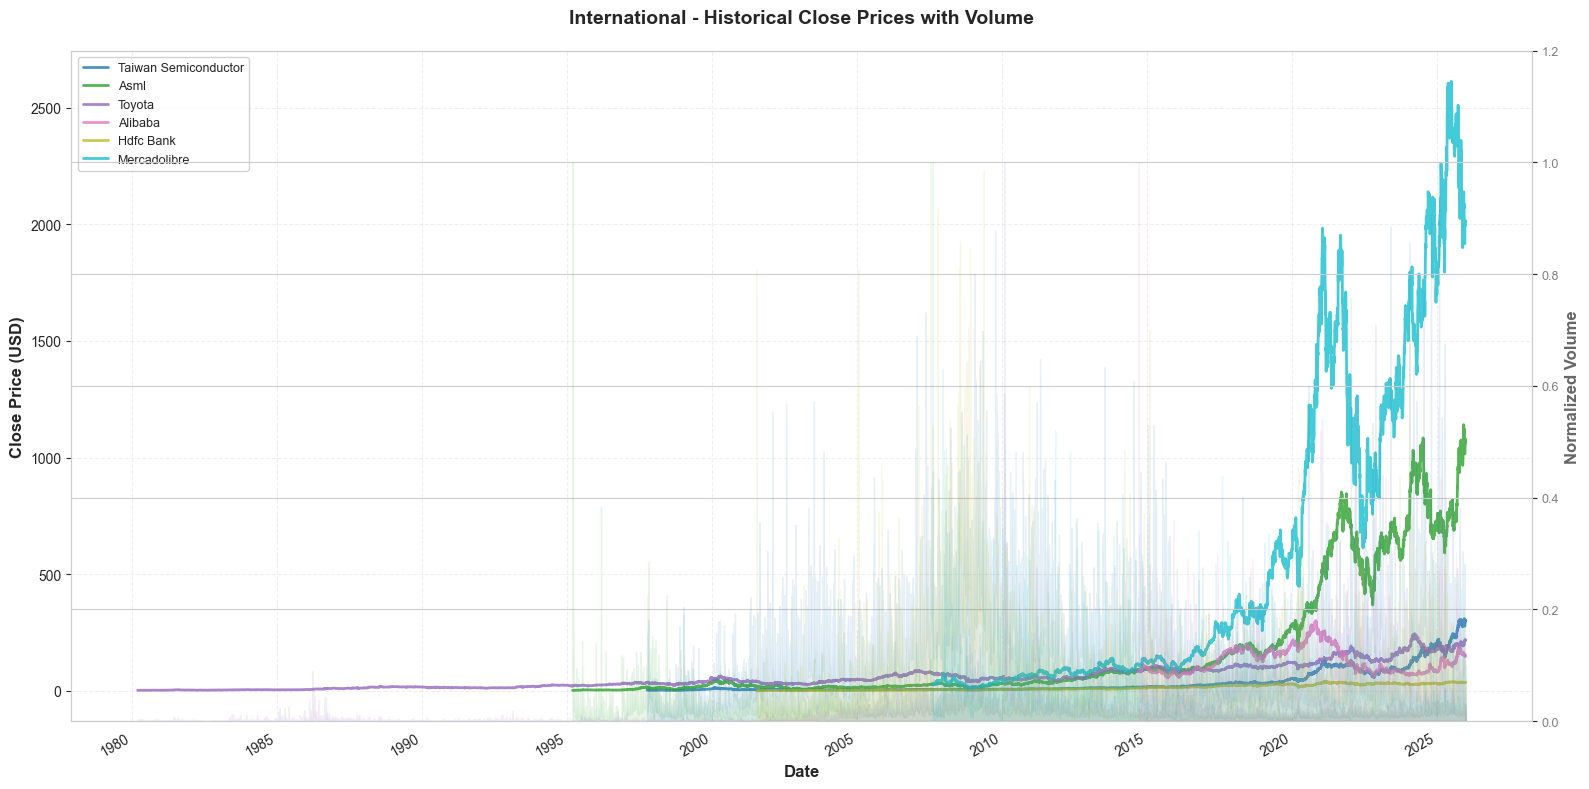

In [143]:
plot_category_chart('International', categories['International'], datasets)

### 9.17 Crypto

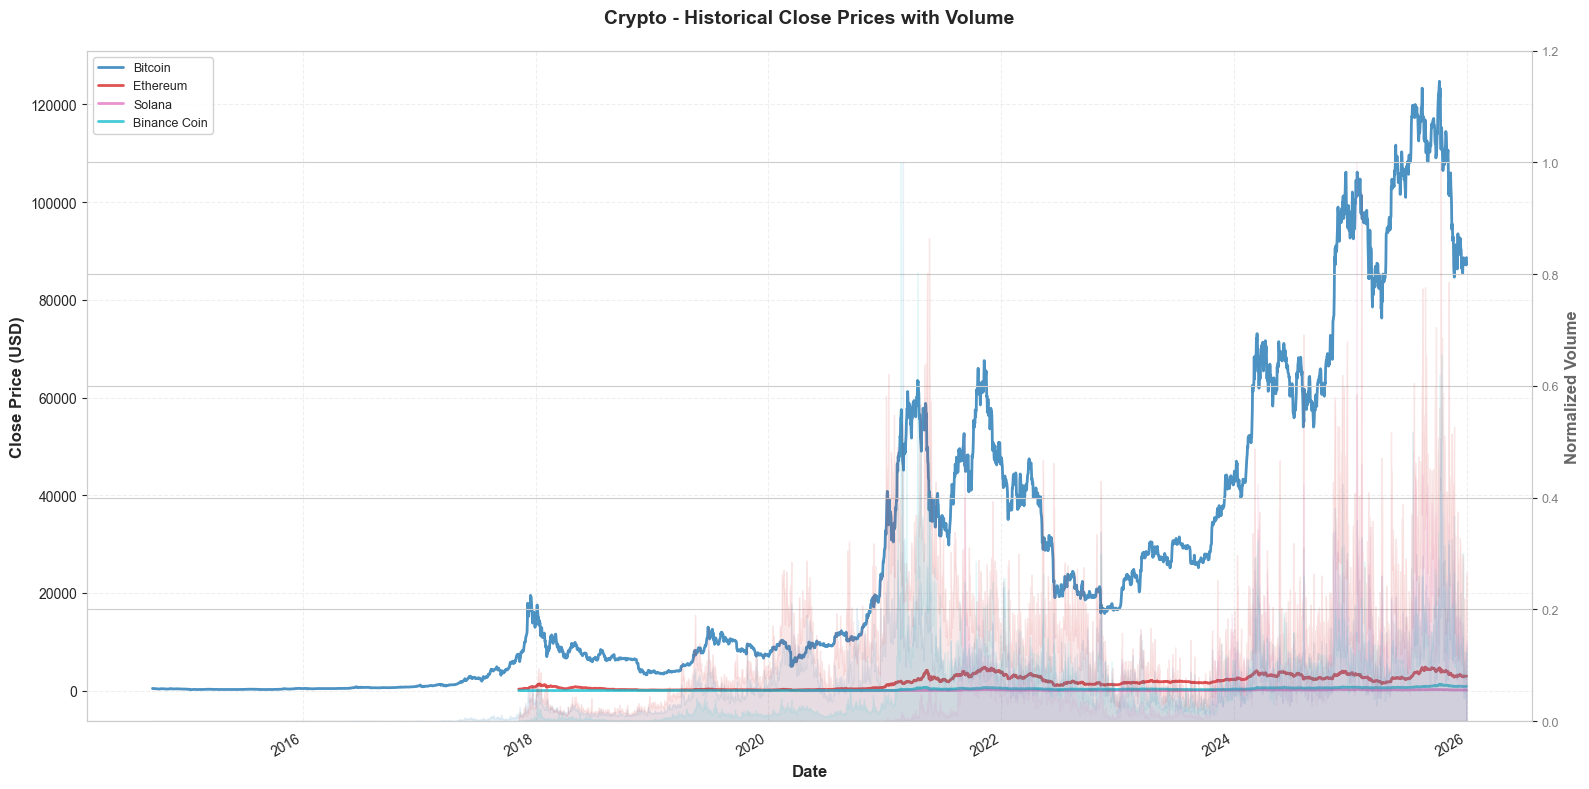

In [144]:
plot_category_chart('Crypto', categories['Crypto'], datasets)

### 9.18 Indices & Macro

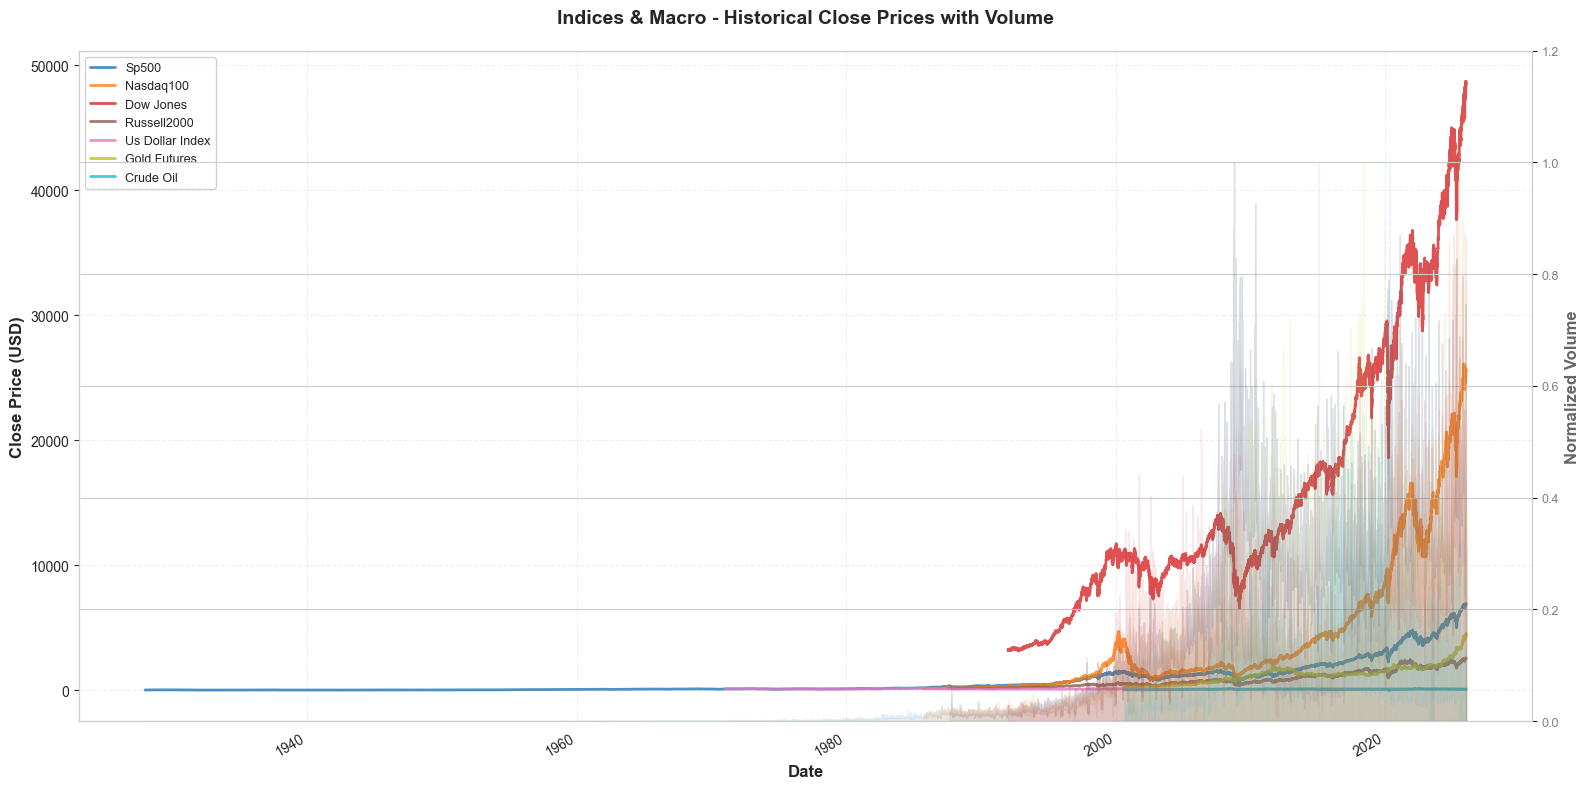

In [145]:
plot_category_chart('Indices & Macro', categories['Indices & Macro'], datasets)

## Summary

This notebook provides a comprehensive overview of the AttentionTrader dataset:
- Dataset coverage and temporal analysis
- Data quality assessment
- Category distribution across 18 categories
- Visual representations of the data structure
- Price and volume charts for all categories

The dataset includes 101 tickers across:
- **Technology & AI**: Big Tech, Semiconductors, Cloud/SaaS, Cybersecurity (26 tickers)
- **Finance & Fintech**: Banking, Payments (10 tickers)
- **Healthcare & Biotech**: Weight Loss, Pharma, Genomics (10 tickers)
- **Consumer**: Discretionary, Staples (10 tickers)
- **Energy & Industrials**: Energy, Industrials & Materials (11 tickers)
- **Real Estate, Telecom & Media** (7 tickers)
- **International & Crypto** (10 tickers: 6 international + 4 crypto)
- **Indices & Macro**: Market indices, Dollar, Gold, Oil (7 tickers)

Ready for further analysis including:
- Price trend analysis
- Volatility studies
- Correlation analysis
- Feature engineering for machine learning models